In [25]:
import random
import pandas as pd
import matplotlib.pyplot as plt

from scripts import analysis

In [34]:
low_activity_repos = pd.read_csv("data/fake_stars_low_activity_repos.csv")
low_activity_repos.head()

,repo_id,repo_names,n_stars,n_stars_low_activity,p_stars_low_activity
0,NaN,popofiraco/pancake-swap,377,377,1.0
1,NaN,vergessene/Library-Needle,358,358,1.0
2,NaN,lucasilmar/dmgunz,497,497,1.0
3,NaN,CreepyCat01/Wondershare-Filmora,51,51,1.0
4,NaN,JHONNEX/ValorantCheat-External,51,51,1.0


In [44]:
stars_by_month = analysis.get_stars_by_month("low_activity")
stars_by_month["n_stars_other"] = (
    stars_by_month.n_stars - stars_by_month.n_stars_low_activity
)
stars_by_month["seems_like_compaign"] = (
    stars_by_month["n_stars_low_activity"] >= 50
) & (stars_by_month["n_stars_low_activity"] / stars_by_month["n_stars"] >= 0.2)

repos_all = set(stars_by_month.repo)
repos_with_compaign = set(
    stars_by_month[stars_by_month.seems_like_compaign].repo
) & set(
    sum(
        low_activity_repos[
            low_activity_repos.p_stars_low_activity >= 0.2
        ].repo_names.map(lambda x: x.split(",")),
        [],
    ),
)
repos_alive = set(
    sum(
        low_activity_repos[low_activity_repos.repo_id.notna()].repo_names.map(
            lambda x: x.split(",")
        ),
        [],
    )
)

print(f"{len(repos_with_compaign)} of {len(repos_all)} repos with campaign")
print(f"{len(repos_alive)} of {len(repos_all)} repos alive")
print(f"{len(repos_with_compaign & repos_alive)} repos with campaign and alive")
stars_by_month.head()

595 of 4095 repos with compaign
3539 of 4095 repos alive
180 repos with compaign and alive


,repo,month,n_stars,n_stars_low_activity,n_stars_other,seems_like_compaign
0,01072006/der8gyXjjYMQ6KFVAg,2024-04,65,59,6,True
1,05Konz/Blooket-Cheats,2023-08,56,1,55,False
2,05Konz/Blooket-Cheats,2023-09,37,6,31,False
3,05Konz/Blooket-Cheats,2023-10,42,9,33,False
4,05Konz/Blooket-Cheats,2023-11,47,16,31,False


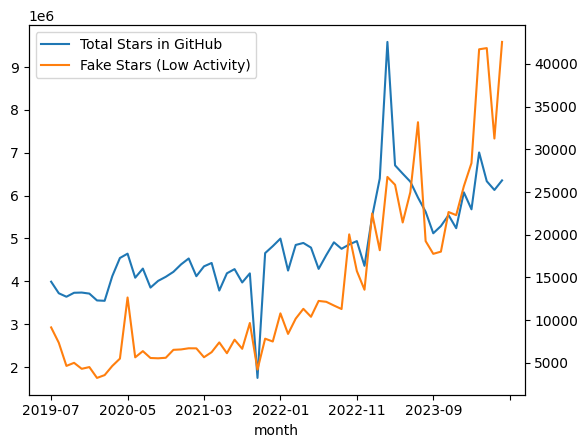

In [96]:
fig, ax = plt.subplots()
pd.read_csv("data/stars_by_month.csv").plot(ax=ax, secondary_y=False, logy=False)
ax2 = (
    stars_by_month[stars_by_month.month != "2024-07"]
    .groupby("month")
    .agg(n_stars_low_activity=("n_stars_low_activity", "sum"))
    .plot(ax=ax, secondary_y=True, logy=False)
)
ax.legend(
    labels=["Total Stars in GitHub", "Fake Stars (Low Activity)"],
    handles=[ax.lines[0], ax2.lines[0]],
)

Text(0.5, 0, '# of Active Months')

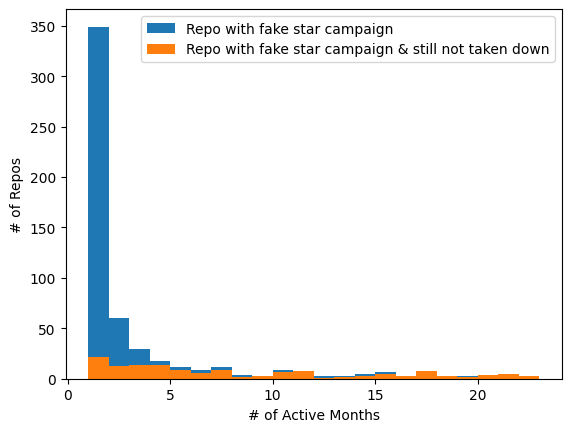

In [70]:
repo_to_months = (
    stars_by_month.groupby("repo")
    .agg(
        n_months=("month", "count"),
    )
    .reset_index()
)

fig, ax = plt.subplots()
repo_to_months[repo_to_months.repo.isin(repos_with_compaign)].plot(
    kind="hist",
    bins=range(1, 24),
    ax=ax,
)
repo_to_months[repo_to_months.repo.isin(repos_with_compaign & repos_alive)].plot(
    kind="hist",
    bins=range(1, 24),
    ax=ax,
)
ax.legend(
    [
        "Repo with fake star campaign",
        "Repo with fake star campaign & still not taken down",
    ]
)
ax.set_ylabel("# of Repos")
ax.set_xlabel("# of Active Months")

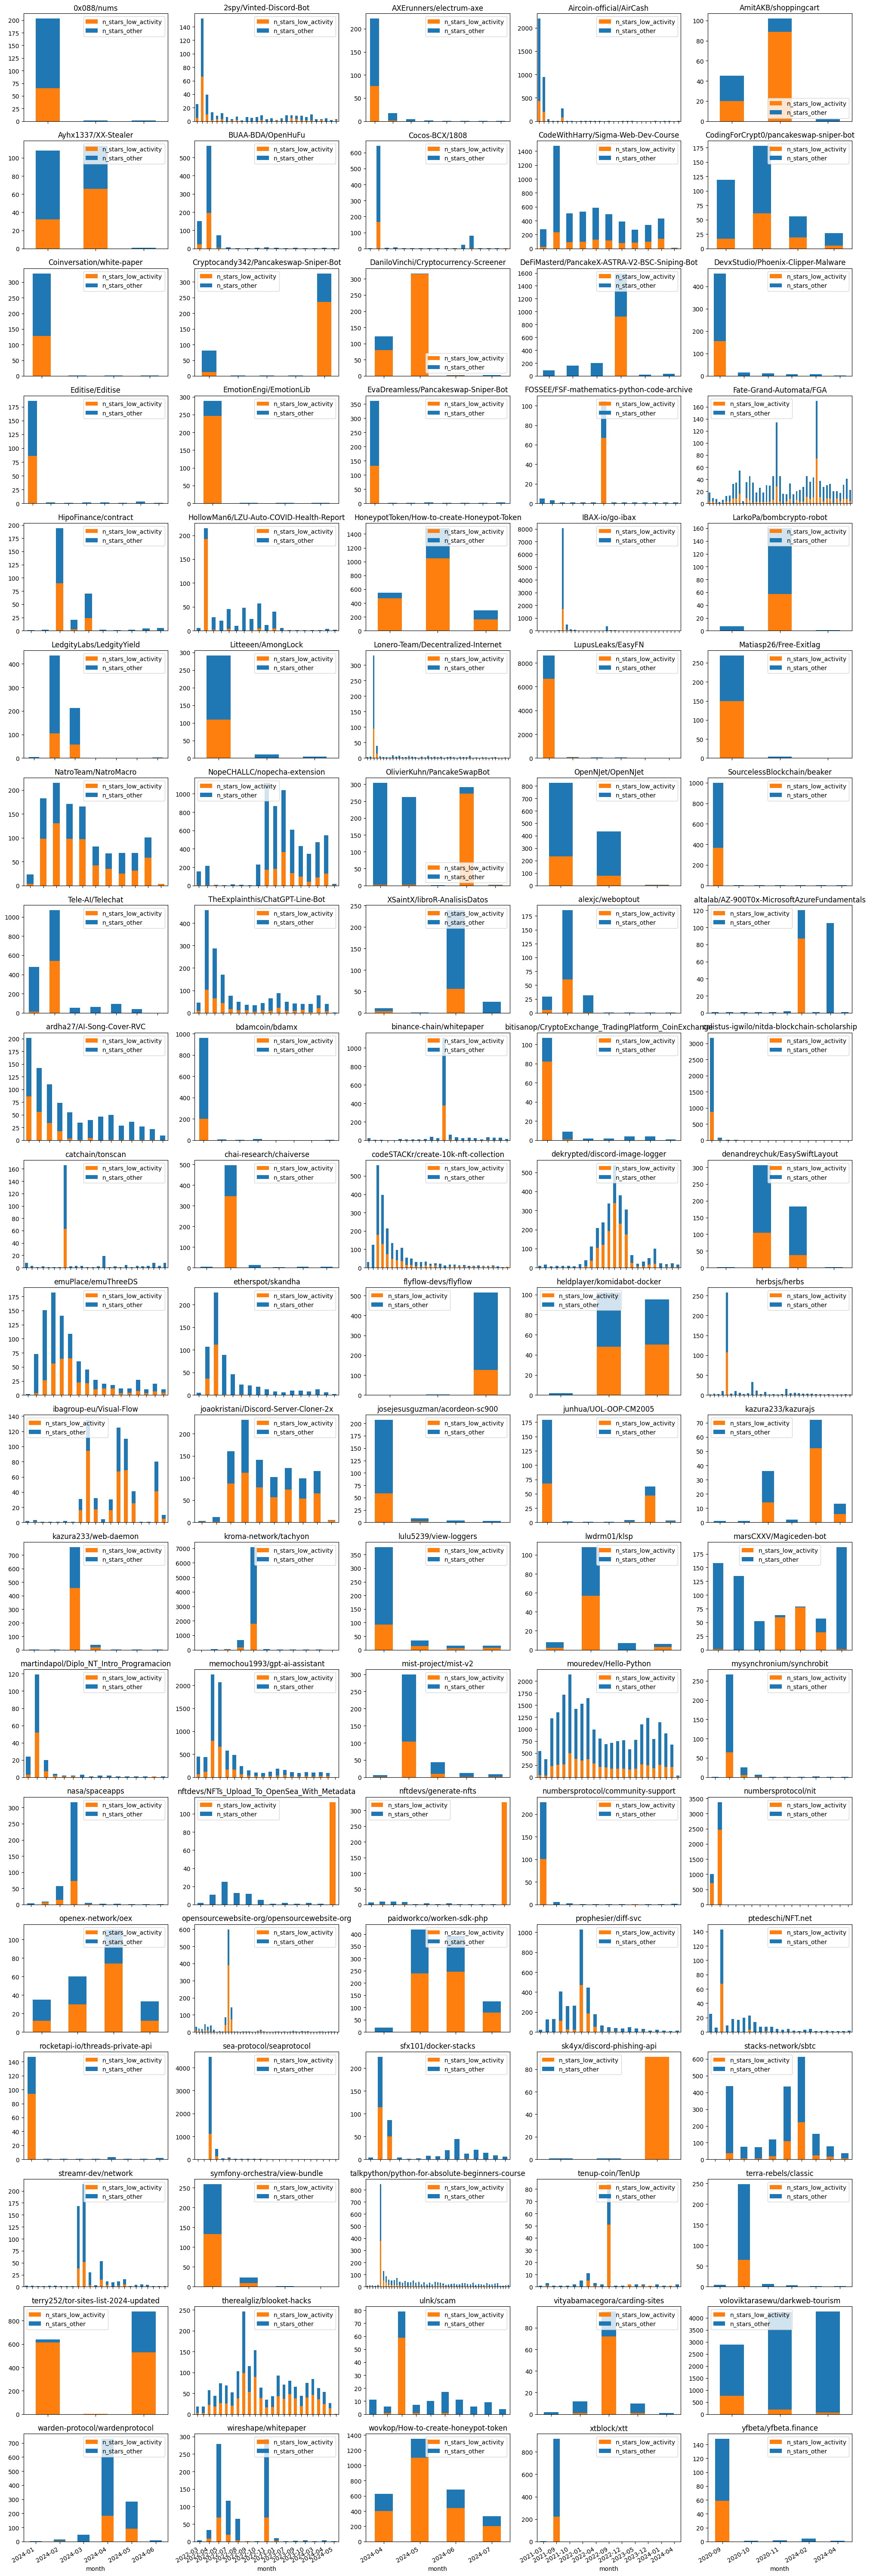

In [74]:
repo_samples = random.sample(
    sorted(
        repos_with_compaign & set(repo_to_months[repo_to_months.n_months >= 3].repo)
    ),
    100,
)

fig, axes = plt.subplots(20, 5, figsize=(20, 60))
for i, (repo, df) in enumerate(
    stars_by_month[stars_by_month.repo.isin(repo_samples)].groupby("repo")
):
    df[["month", "n_stars_low_activity", "n_stars_other"]].plot(
        kind="bar",
        x="month",
        stacked=True,
        ax=axes[i // 5, i % 5],
        title=repo,
        color=["C1", "C0"],
    )
fig.autofmt_xdate()
fig.tight_layout()